In [2]:
import pandas as pd

labels = ["human", "generated"]

with open("autextification2023/data/train/subtask_1/en/train.tsv", "r") as f:
    base_df = pd.read_csv(f, sep="\t", index_col=0)

    train_df = pd.DataFrame({"text": base_df["text"], "label": [0 if t == "human" else 1 for t in base_df["label"]]})

with open("autextification2023/data/test/subtask_1/en/test.tsv", "r") as f:
    base_df = pd.read_csv(f, sep="\t", index_col=0)

    test_df = pd.DataFrame({"text": base_df["text"], "label": [0 if t == "human" else 1 for t in base_df["label"]]})

base_df.head()

,id,prompt,text,label,model,domain
0,15725,NO-PROMPT,It has remained one of my favorite country/swi...,human,NO-MODEL,reviews
1,17108,NO-PROMPT,Even with very light use (hard to get motivate...,human,NO-MODEL,reviews
2,383,"His mother, Ivy Close, who won the first ever ...",She died in 2015 at age 93. She is survived by...,generated,A,news
3,7809,NO-PROMPT,Londonderry Crown Court heard how Heaney false...,human,NO-MODEL,news
4,6215,NO-PROMPT,"Will Genia, Lachie Turner and Berrick Barnes e...",human,NO-MODEL,news


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# Transform the text data to feature vectors
X_train = vectorizer.fit_transform(train_df["text"])
X_test = vectorizer.transform(test_df["text"])

# Labels
y_train = train_df["label"]
y_test = test_df["label"]

In [39]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

# Initialize classifiers
clfs: dict[str, BaseEstimator] = {
    "Logistic Regression": LogisticRegression(C=5, max_iter=1000),
    "Ridge Classifier": RidgeClassifier(alpha=1.0, solver="sparse_cg"),
    "kNN": KNeighborsClassifier(n_neighbors=100),
    "Random Forest": RandomForestClassifier(),
    # L2 penalty Linear SVC
    "Linear SVC": LinearSVC(C=0.1, dual=False, max_iter=1000),
    # L2 penalty Linear SGD
    "Log-loss SGD": SGDClassifier(loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True),
    # NearestCentroid (aka Rocchio classifier)
    "Nearest Centroid": NearestCentroid(),
    # Sparse naive Bayes classifier
    "Complement Naive Bayes": ComplementNB(alpha=0.1),
    # Multi-layer perceptron classifier
    "Multi-layer Perceptron": MLPClassifier(solver="adam", alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42),
}

In [21]:
import time

from sklearn.metrics import accuracy_score

# Train the classifiers and measure accuracy
train_time = []
test_time = []
accuracy = []
for name, clf in clfs.items():
    start = time.perf_counter()
    clf.fit(X_train, y_train)
    train_time.append(time.perf_counter() - start)

    start = time.perf_counter()
    y_pred = clf.predict(X_test)
    test_time.append(time.perf_counter() - start)

    accuracy.append(accuracy_score(y_test, y_pred))

# Create dataframe for report
classifier_names = [n for n in clfs]
results = pd.DataFrame({
    "classifier": classifier_names,
    "training (sec)": train_time,
    "testing (sec)": test_time,
    "accuracy (%)": [100 * v for v in accuracy]
}, index=classifier_names)
results.sort_values(by=["accuracy (%)"], ascending=False, ignore_index=True, inplace=True)

results

,classifier,training (sec),testing (sec),accuracy (%)
0,Logistic Regression,0.573811,0.001875,59.806706
1,Ridge Classifier,0.144466,0.001382,59.683034
2,Multi-layer Perceptron,86.233865,0.004050,59.458593
3,Linear SVC,0.171866,0.001190,58.867717
4,Log-loss SGD,0.031034,0.001163,57.667644
5,Random Forest,81.879504,1.636565,57.479846
6,Complement Naive Bayes,0.008543,0.003369,56.847746
7,kNN,0.004485,12.328544,52.940638
8,Nearest Centroid,0.009811,0.004739,51.250458


<Axes: title={'center': 'Accuracy of various classifiers'}, ylabel='classifier'>

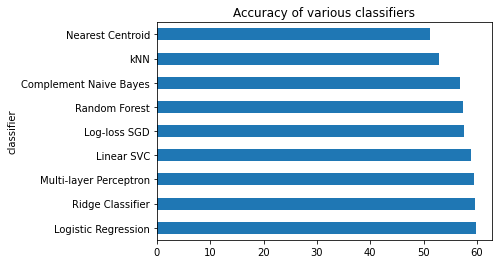

In [24]:
results.plot(x="classifier", y="accuracy (%)", kind="barh", title="Accuracy of various classifiers", legend=False)

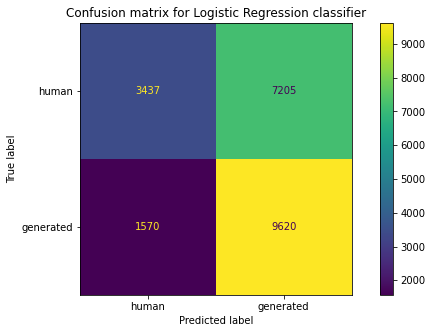

In [35]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, DetCurveDisplay, PrecisionRecallDisplay, classification_report

y_pred = clfs[0][0].predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
_ = ax.set_title("Confusion matrix for Logistic Regression classifier")

In [43]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       human       0.69      0.32      0.44     10642
   generated       0.57      0.86      0.69     11190

    accuracy                           0.60     21832
   macro avg       0.63      0.59      0.56     21832
weighted avg       0.63      0.60      0.57     21832

